## Installations

In [ ]:
# !pip uninstall nltk -y
# !pip install -U nltk

In [ ]:
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
# !pip install deep_translator
# !pip install langdetect 
# !pip install textblob
# !pip install wordcloud

# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')


## Imports

In [166]:
import numpy as np
import pandas as pd

### Read File

In [168]:
df = pd.read_csv('ubuntu_customer_msg_small.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)], axis = 1, inplace = True)
pd.set_option('display.max_colwidth', None)

In [169]:
df_sample = df.sample(n=30000, random_state=1)

In [170]:
df_sample.head()

,raw_text
181970,Is there a command that I can use to reload the xserver without restarting the system?
170,can someone tell me what I do with a .tar.gz.part file?
147729,"so does anyone know if its possible to have both Ubuntu and Windows on the same comp, like Mac and Windows on MacBooks?"
153112,"Ubuntu version 10.04.1 is the LTS one that is supported to April 2013, right?"
40659,how do i know which driver my wirelesscard is currently using?


In [171]:
df_sample.shape

(30000, 1)

In [172]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 181970 to 143787
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   raw_text  30000 non-null  object
dtypes: object(1)
memory usage: 468.8+ KB


**Observation**: No null data found

## Data cleaning: Prepare the text for topic modeling

We need to:

* Make the text lowercase
* Remove punctuation
* Remove words containing numbers


Once we have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [173]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.corpus import stopwords
from deep_translator import GoogleTranslator
from tqdm import tqdm
from textblob import TextBlob
from langdetect import detect
import re

In [174]:
from langdetect import detect

In [175]:
def translate_to_english(to_translate):
    try:
        if detect(to_translate) != 'en':
            translated = GoogleTranslator(source='auto', target='english').translate(to_translate)
            return translated
        return to_translate
    except:
        return to_translate

In [176]:
greetings = ['hi', 'hello', 'hey', 'greetings', 'howdy', 'folks', 'folk']
greetings_pattern = r'\b(' + '|'.join(greetings) + r')\b'

# Method to clean the text and remove all the unnecessary elements.
def cleaned_text(sentence):
    sentence = translate_to_english(sentence)
    sentence = sentence.lower()
    sentence = re.sub("[\[].*?[\]]", "", sentence)
    sentence = re.sub(greetings_pattern, "", sentence)    
    sentence = re.sub(r'[^\w\s]','', sentence) 
    sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
    return sentence

In [177]:
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatized_text(sentence):
    # tokenize into words
    words = nltk.word_tokenize(sentence)
    
    # remove stop words
    words = [word for word in words if word not in stopwords.words("english")]

    # tokenize the sentence and find the Part Of Speech(POS) tag for each token
    nltk_tagged = nltk.pos_tag(words)
    
    # tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    
    lemmatized_sentence = []
    # use tag to lemmatize the token
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [178]:
len(df_sample)

30000

In [179]:
# Add a new column lemmatized_raw_text
df_sample['lemmatized_raw_text'] = df_sample['raw_text'].apply(lambda x: lemmatized_text(cleaned_text(x)))

In [180]:
df_sample.head()

,raw_text,lemmatized_raw_text
181970,Is there a command that I can use to reload the xserver without restarting the system?,command use reload xserver without restart system
170,can someone tell me what I do with a .tar.gz.part file?,someone tell targzpart file
147729,"so does anyone know if its possible to have both Ubuntu and Windows on the same comp, like Mac and Windows on MacBooks?",anyone know possible ubuntu window comp like mac window macbooks
153112,"Ubuntu version 10.04.1 is the LTS one that is supported to April 2013, right?",ubuntu version lts one support april right
40659,how do i know which driver my wirelesscard is currently using?,know driver wirelesscard currently use


In [181]:
tqdm.pandas()

# function to extract the POS tags 
def extract_pos_tag(sentence):
    # Create a textblob object
    blob = TextBlob(sentence)

    # extract words with tags 'NN'(all nouns), join them and return
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])
    
df_sample["raw_text_POS_removed"] = df_sample.progress_apply(lambda x: extract_pos_tag(x.lemmatized_raw_text), axis=1)
df_sample["length"] = df_sample.progress_apply(lambda x: len(x.raw_text_POS_removed), axis=1)

100%|█████████████████████████████████| 30000/30000 [00:00<00:00, 206845.22it/s]


In [182]:
df_sample.head()

,raw_text,lemmatized_raw_text,raw_text_POS_removed,length
181970,Is there a command that I can use to reload the xserver without restarting the system?,command use reload xserver without restart system,command use reload xserver restart system,41
170,can someone tell me what I do with a .tar.gz.part file?,someone tell targzpart file,someone file,12
147729,"so does anyone know if its possible to have both Ubuntu and Windows on the same comp, like Mac and Windows on MacBooks?",anyone know possible ubuntu window comp like mac window macbooks,anyone window mac window,24
153112,"Ubuntu version 10.04.1 is the LTS one that is supported to April 2013, right?",ubuntu version lts one support april right,version support april right,27
40659,how do i know which driver my wirelesscard is currently using?,know driver wirelesscard currently use,,0


## EDA
### Visualizing data according to the length of the raw text character

In [183]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import wordnet as wn

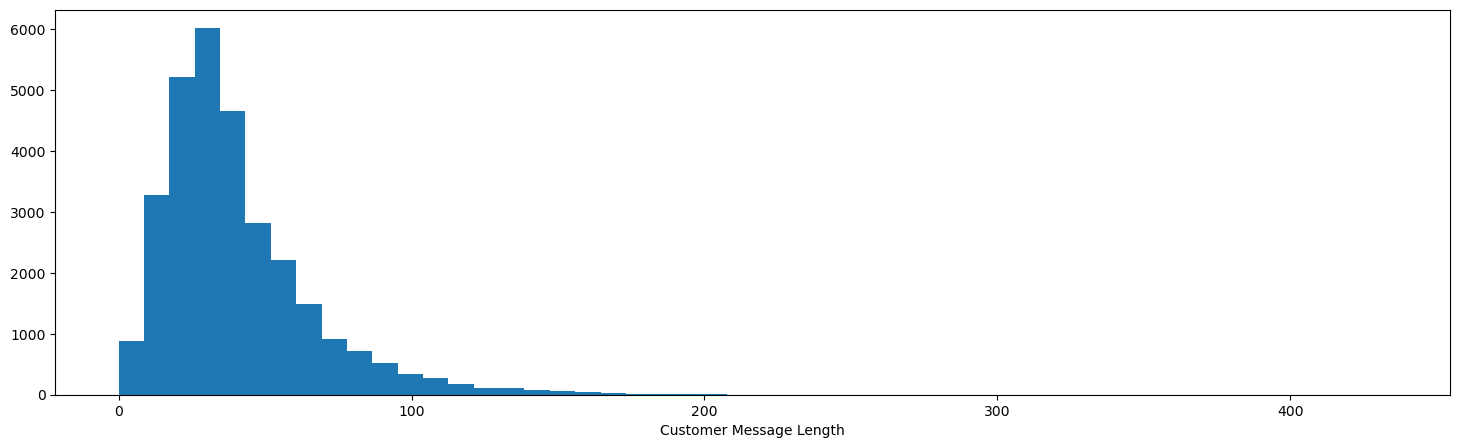

In [184]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(18,5))
plt.hist(df_sample.length, bins=50)
plt.xlabel("Customer Message Length")
plt.show()

### Word cloud to find the top 50 words by frequency among all

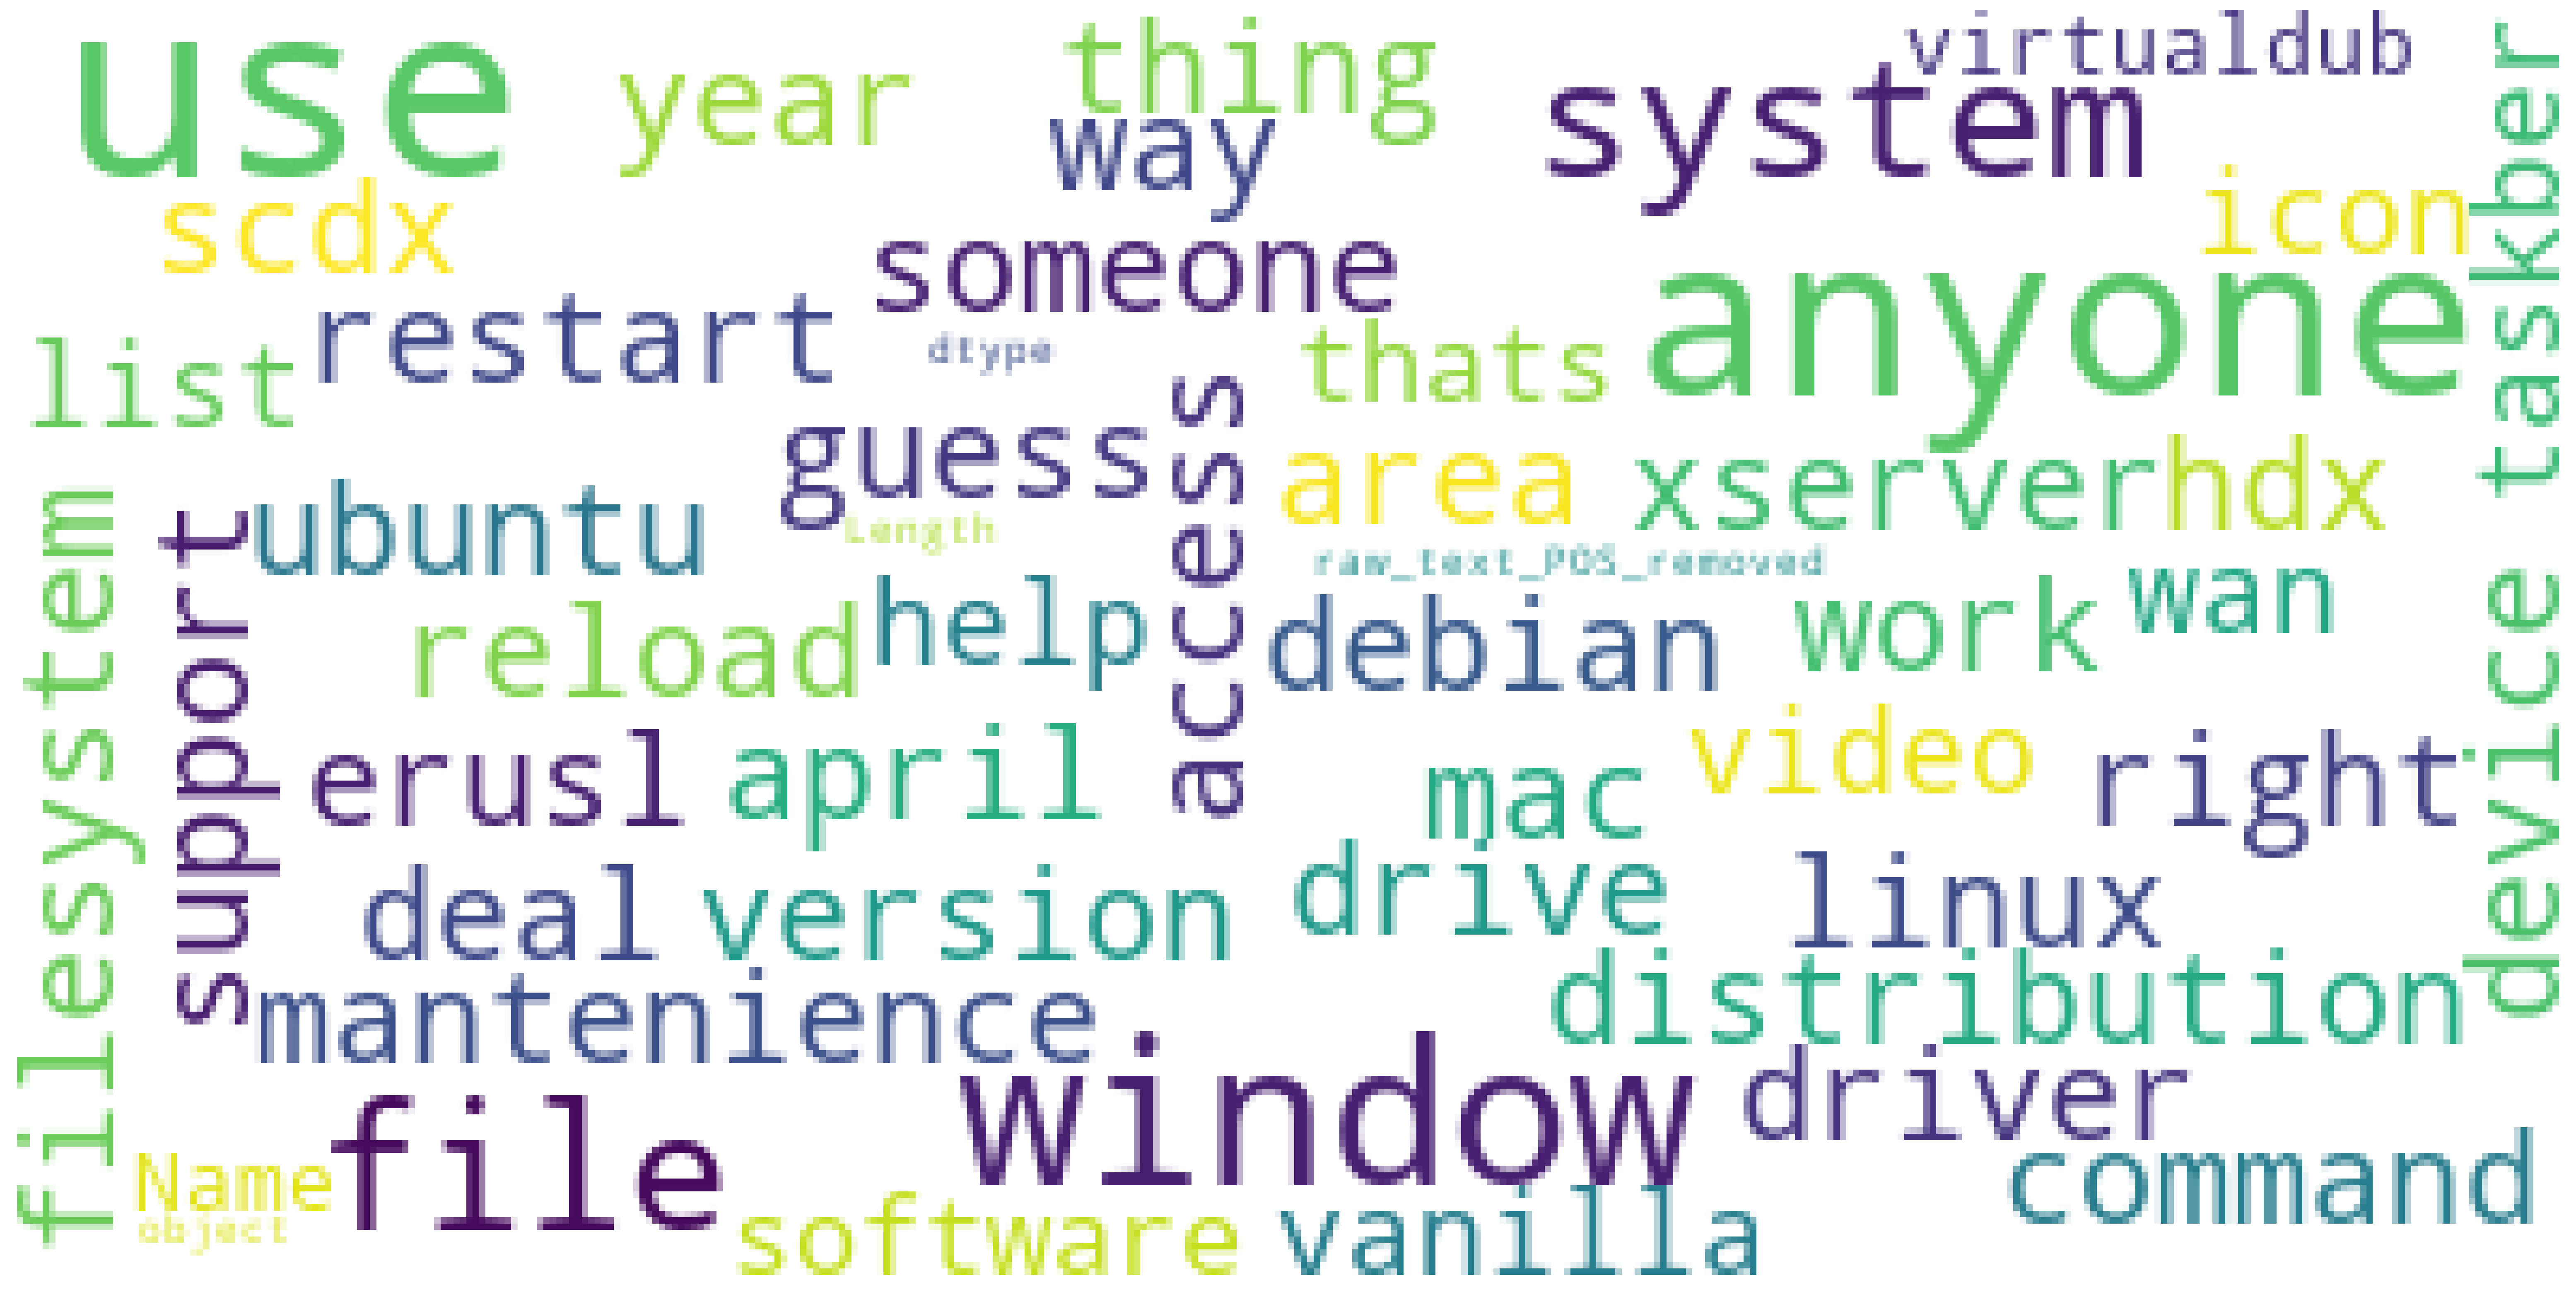

In [185]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(
    background_color='white',
    stopwords=stop,
    max_words=100,
    max_font_size=40, 
    random_state=42
    ).generate(str(df_sample['raw_text_POS_removed'][:]))

fig = plt.figure(figsize=(80,60))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Find top 30 n ngrams

In [186]:
# top n nngram frequency among the cleaned raw text 
def get_top_n_words(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [187]:
# top 30 unigrams, bigram and trigram by frequency among all the complaints
common_words_1 = get_top_n_words(df_sample['raw_text_POS_removed'].values.astype('U'), 30)
common_words_2 = get_top_n_words(df_sample['raw_text_POS_removed'].values.astype('U'), 30, (2, 2))
common_words_3 = get_top_n_words(df_sample['raw_text_POS_removed'].values.astype('U'), 30, (3, 3))
print(common_words_1)
print(common_words_2)
print(common_words_3)

[('use', 4191), ('file', 2802), ('work', 2751), ('help', 2159), ('im', 2076), ('way', 2042), ('install', 1935), ('ubuntu', 1766), ('problem', 1664), ('window', 1542), ('package', 1526), ('try', 1504), ('boot', 1359), ('question', 1350), ('command', 1336), ('partition', 1276), ('program', 1275), ('guy', 1259), ('cd', 1220), ('server', 1083), ('change', 1065), ('drive', 1060), ('linux', 1038), ('time', 990), ('version', 976), ('dont', 944), ('need', 931), ('driver', 929), ('computer', 922), ('idea', 876)]
[('command line', 278), ('im use', 277), ('need help', 199), ('doesnt work', 195), ('im problem', 117), ('root password', 110), ('im try', 99), ('file directory', 91), ('im trouble', 86), ('package manager', 86), ('program use', 85), ('cunt cunt', 85), ('guy im', 83), ('work ubuntu', 82), ('boot cd', 81), ('try use', 80), ('network manager', 79), ('home directory', 79), ('card work', 74), ('version ubuntu', 68), ('nvidia driver', 68), ('video card', 68), ('wireless network', 65), ('use 

## Feature Extraction

In [188]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF

In [189]:
# initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")

In [190]:
# frequency of terms that occur in a collection of document
document_term_matrix = tfidf.fit_transform(df_sample.raw_text_POS_removed)

In [191]:
# loading nmf_model with the n_components i.e 6
num_topics = 6
nmf_model = NMF(n_components=num_topics, random_state=40) 

In [192]:
nmf_model.fit(document_term_matrix)
len(tfidf.get_feature_names_out())

4867

In [193]:
# print the top 15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'\033[1mTHE TOP 15 WORDS FOR TOPIC #{index + 1}', '\033[0m')  
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #1 
['mount', 'server', 'try', 'question', 'guy', 'linux', 'drive', 'program', 'im', 'window', 'install', 'boot', 'cd', 'partition', 'use']


THE TOP 15 WORDS FOR TOPIC #2 
['guy', 'card', 'dont', 'time', 'server', 'driver', 'network', 'anybody', 'issue', 'im', 'error', 'try', 'problem', 'need', 'help']


THE TOP 15 WORDS FOR TOPIC #3 
['software', 'command', 'search', 'dependency', 'repository', 'way', 'deb', 'source', 'list', 'manager', 'aptget', 'download', 'version', 'install', 'package']


THE TOP 15 WORDS FOR TOPIC #4 
['access', 'program', 'share', 'root', 'edit', 'copy', 'download', 'change', 'permission', 'line', 'way', 'folder', 'directory', 'command', 'file']


THE TOP 15 WORDS FOR TOPIC #5 
['dont', 'computer', 'video', 'im', 'linux', 'network', 'sound', 'try', 'wireless', 'problem', 'idea', 'doesnt', 'driver', 'card', 'work']


THE TOP 15 WORDS FOR TOPIC #6 
['server', 'pc', 'problem', 'machine', 'guy', 'desktop', 'bit', 'card', 'support', 'anybo

In [194]:
# best topic for each complaint in terms of integer value 0,1,2,3,4 & 5
topic_results = nmf_model.transform(document_term_matrix)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 3, 0, ..., 4, 1, 0])

In [195]:
df_sample['Topic'] = topic_results.argmax(axis = 1)

In [196]:
df_topic = df_sample.groupby('Topic').head(3)

In [197]:
df_topic.sort_values('Topic')

,raw_text,lemmatized_raw_text,raw_text_POS_removed,length,Topic
181970,Is there a command that I can use to reload the xserver without restarting the system?,command use reload xserver without restart system,command use reload xserver restart system,41,0
147729,"so does anyone know if its possible to have both Ubuntu and Windows on the same comp, like Mac and Windows on MacBooks?",anyone know possible ubuntu window comp like mac window macbooks,anyone window mac window,24,0
40659,how do i know which driver my wirelesscard is currently using?,know driver wirelesscard currently use,,0,0
69755,can someone get me the link to the kubuntu ISO torrent?,someone get link kubuntu iso torrent,someone get torrent,19,1
79581,can anyone help me reinstall grub correctly from the 11.04 x64 live cd?,anyone help reinstall grub correctly x live cd,anyone help grub cd,19,1
78238,"Hi im writing a script that includes the mount volume, but when I execute it I get the obvious error that it needs to be run by root. I dont want to have to use sudo to use the script. can some 1 help me solve this?",im write script include mount volume execute get obvious error need run root dont want use sudo use script help solve,script mount volume error need dont use sudo use script help,60,1
51107,hi can anyone tell me how to install jre2 on my ubuntu 5.04 ? it cannot find the package sun-j2re1.5,anyone tell install jre ubuntu find package sunjre,anyone jre package sunjre,25,2
146241,"Can someone tell me what's the process for reporting bugs with patches? I read somewhere that you can't triage your own bug, but when my bug with a patch is sitting there as unknown for 2.5 weeks with any comment from anyone it's a little absurd. :-/",someone tell whats process report bug patch read somewhere cant triage bug bug patch sit unknown week comment anyone little absurd,someone tell report bug patch read triage bug bug patch sit week comment anyone,79,2
115454,"jre is only the runtime, JDK contains libraries to actually develop stuff.",jre runtime jdk contain library actually develop stuff,jre runtime jdk stuff,21,2
107205,Does anyone know how to change the repositories that the 'update-manager' uses for updating?,anyone know change repository updatemanager us update,anyone change repository,24,3


In [198]:
# topic dictionary
# Topic_names = { 
#     0: 'Hardware and System Setup',
#     1: 'Network and Connectivity',
#     2: 'File and Folder Management',
#     3: 'System Operations',
#     4: 'Software Installation',
#     5: 'Disk and Storage Management',
# }

Topic_names = {
    0: "Hardware and Software Setup",
    1: "Network and Connectivity Issues",
    2: "File and Directory Management",
    3: "Software Installation and Dependencies",
    4: "System Setup and Partitioning",
    5: "General Inquiries and Support"
}

df_sample['Topic'] = df_sample['Topic'].map(Topic_names)

In [199]:
# df_sample.drop('Topic', axis=1)

In [200]:
df_sample[['raw_text','Topic']].head()


,raw_text,Topic
181970,Is there a command that I can use to reload the xserver without restarting the system?,Hardware and Software Setup
170,can someone tell me what I do with a .tar.gz.part file?,Software Installation and Dependencies
147729,"so does anyone know if its possible to have both Ubuntu and Windows on the same comp, like Mac and Windows on MacBooks?",Hardware and Software Setup
153112,"Ubuntu version 10.04.1 is the LTS one that is supported to April 2013, right?",General Inquiries and Support
40659,how do i know which driver my wirelesscard is currently using?,Hardware and Software Setup


### Modeling

In [201]:
training_data = df_sample[['raw_text','Topic']]

In [202]:
# transform to vector representation
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.raw_text)

# transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [203]:
from sklearn.model_selection import train_test_split

# Performing Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train:\033[1m {X_train.shape}", '\033[0m')
print(f"Shape of y_train:\033[1m {y_train.shape}", '\033[0m')
print(f"Shape of X_test:\033[1m {X_test.shape}", '\033[0m')
print(f"Shape of y_test:\033[1m {y_test.shape}", '\033[0m')

Shape of X_train: (22500, 23385) 
Shape of y_train: (22500,) 
Shape of X_test: (7500, 23385) 
Shape of y_test: (7500,) 


In [204]:
TOPICS = [
    "Hardware and Software Setup",
    "Network and Connectivity Issues",
    "File and Directory Management",
    "Software Installation and Dependencies",
    "System Setup and Partitioning",
    "General Inquiries and Support"
]

#### Logistic Regression

In [205]:
import seaborn as sns

In [206]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [207]:
# Logistic Regression model
model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

In [208]:
# F1 Score using weighted average method
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.7142663025076845

In [209]:
# Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, penalty='l1',solver='saga')
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

In [210]:
# F1 Score of tuned model using weighted average method
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.7467986914706191

In [211]:
# Create a function to evaluate models
def eval_model(y_test, y_pred, model_name):
    # print classification report of classifier
    print(f"\033[1mCLASSIFICATION REPORT for {model_name}\n", '\033[0m')
    print(classification_report(y_test, y_pred, target_names=TOPICS))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,6))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=TOPICS, yticklabels=TOPICS)
    plt.show()
    
    return

CLASSIFICATION REPORT for LOGISTIC REGRESSION
 
                                        precision    recall  f1-score   support

           Hardware and Software Setup       0.81      0.69      0.75       734
       Network and Connectivity Issues       0.65      0.51      0.57       793
         File and Directory Management       0.71      0.87      0.78      3071
Software Installation and Dependencies       0.78      0.67      0.72       728
         System Setup and Partitioning       0.84      0.74      0.79      1041
         General Inquiries and Support       0.83      0.69      0.75      1133

                              accuracy                           0.75      7500
                             macro avg       0.77      0.69      0.73      7500
                          weighted avg       0.76      0.75      0.75      7500



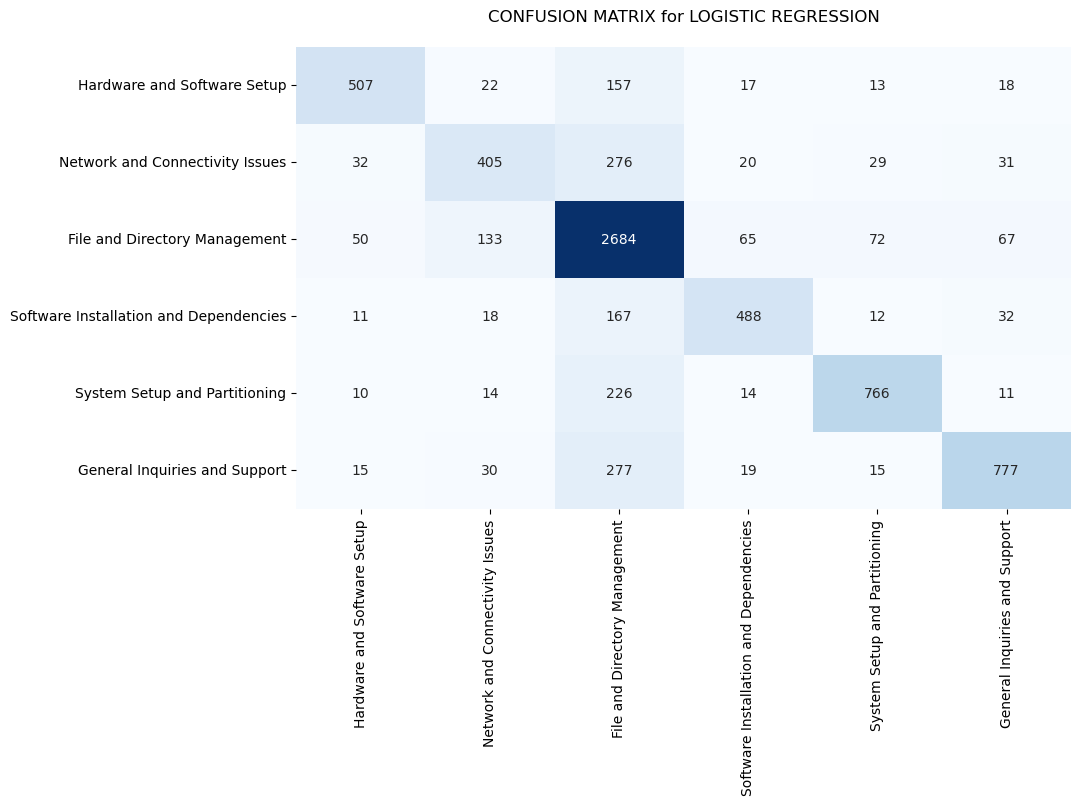

In [212]:
# Evaluate the tuned Logistic Regression classifier
eval_model(y_test, y_pred_lr_tuned, model_name)

In [213]:
summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score (untuned)': round(f1_lr, 2), 'F1 Score (tuned)': round(f1_lr_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.71,0.75


### Future improvements
* Data Cleaning
    * Remove or handle statements containing profanity.
    * Normalize multilingual data to English, or drop non-English data.
    * Handle incorrect spellings.
    * Split combined words (e.g., "heythere" to "hey there").
    * Handle noisy data (Repetition of same words, etc) 
    
* Modeling
    * Experiment with additional modeling techniques to identify the best-performing approach.